# Simulation of the growth and development of an apple tree 2 - Architecture

In [1]:
from pgljupyter import *
from openalea.lpy import *

In [2]:
from training.utils.namedenum import enum
import numpy as np

gutypes = enum('ShortGU', 'LongGU', 'Inflo', 'TrunkGU')
gufate  = enum('Proleptic','Sylleptic','Blind')

def is_sylleptic(gufate):
    return gufate == Sylleptic

def is_proleptic(gufate):
    return gufate == Proleptic


## Growth unit succession and flowering among years

In [3]:
sucessiontypes = [ShortGU, LongGU, Inflo]
successionmatrix = [[0.6,  0.0,  0.4],
                    [0.35, 0.25, 0.4],
                    [0.95, 0.05,  0]
                   ]
#from random import uniform, seed
from numpy import cumsum
from numpy.random import uniform


def realization_in_probaranges(probas):
    cumsum_probs = cumsum(probas)
    totalprob = cumsum_probs[-1]
    cumsum_probs /= totalprob
    assert abs(cumsum_probs[-1] -1) < 1e-5
    unif_realization = float( uniform(0,1) )
    i = 0
    while unif_realization >= cumsum_probs[i] : i += 1
    return i

def succession(gutype, successionmatrix = successionmatrix):
    if gutype == TrunkGU : return LongGU
    probas = successionmatrix[gutype]
    return sucessiontypes[realization_in_probaranges(probas)]


Inflo
ShortGU
Succession Probabilities


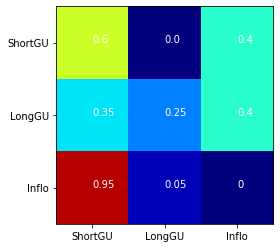

In [4]:
# Example of Use
from matplotlib.pyplot import *
%matplotlib inline

print(succession(LongGU))
print(succession(Inflo))

print('Succession Probabilities')
imshow(successionmatrix, cmap='jet', vmin = 0, vmax = 1)
xticks(range(3),map(str,sucessiontypes))
yticks(range(3),map(str,sucessiontypes))
for i in range(3):
    for j in range(3):
        text(i,j,str(successionmatrix[j][i]), color='w')
show()

## Branching probability

In [5]:
def normalize(matrix):
    def nml(a):
        s = sum(a)
        return a/s
    matrix = np.array(matrix)
    return np.array([nml(probas) for probas in matrix])
    
lateralfates = [Blind, Proleptic, Sylleptic]
branchingmatrixfate = normalize([
    [0.4,0.6,0],
    [0.3,0.7,0],
    [0.4,0.6,0],
    [0.7,0.3,0],
    [0.4,0.25,0.35],
    [0.4,0.25,0.35],
    [0.35,0.2,0.45],
    [0.35,0.3,0.35],
    [0.3,0.55,0.15],
    [0.65,0.35,0]
])


lateraltypes = [ShortGU, LongGU, Inflo]
branchingmatrixtype = normalize([
    [0.5,  0.0, 0],
    [0.5,  0.5, 0],
    [0.75, 0.25,0],
    [1,    0,   0],
    [1,    0,   0],
    [0.5,  0.5, 0],
    [0.25, 0,   0.75],
    [0.15, 0.35,0.5],
    [0.15, 0.7, 0.15],
    [0.4,  0.6, 0]
])

branchingmatrixtype = np.array(branchingmatrixtype)

def branching(gutype, u, branchingmatrixfate = branchingmatrixfate, branchingmatrixtype = branchingmatrixtype):
    if gutype in [ShortGU, Inflo] : return Blind, None
    i, _ = divmod(u, 0.1)
    probafate = branchingmatrixfate[int(i)]
    fate = lateralfates[realization_in_probaranges(probafate)]
    if fate == Blind: return Blind, None
    probatype = branchingmatrixtype[int(i)]
    ptype = lateraltypes[realization_in_probaranges(probatype)]
    if fate == Sylleptic and ptype == Inflo:
        fate = Proleptic
    return fate, ptype

num2str = lambda v : '%.1f' % v
from matplotlib.pyplot import *
def plot_matrix(matrix, labels):
    imshow(matrix, cmap='jet', vmin = 0, vmax = 1)
    xticks(range(len(labels)),map(str,labels),rotation=90)
    nb = len(matrix)
    yticks(range(nb),map(num2str,[0.1*i for i in range(nb)]))
    for i in range(len(labels)):
        for j in range(nb):
            text(i-0.5,j,num2str(matrix[j][i]), color='w')
    show()
    

Branching Fate Probabilities 


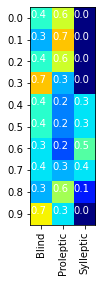

Branching Type Probabilities


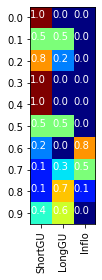

In [6]:
# Example of Use

print('Branching Fate Probabilities ')
plot_matrix(branchingmatrixfate, lateralfates)


print('Branching Type Probabilities')
plot_matrix(branchingmatrixtype, lateraltypes)


In [7]:
def probalong(u,maxrank = 0.5, probamax = 0.5, rankspan = 0.5):
    if maxrank < 0: maxrank = 0
    elif maxrank >=1 : maxrank = 0.9
    if rankspan > 0.5 : rankspan = 0.5
    elif rankspan < 0 : rankspan = 0
    
    minu = maxrank-rankspan
    maxu = maxrank+rankspan
    if minu < -0.1:
        maxu = maxu-minu
        minu = -0.1
    if maxu > 1:
        minu -= (maxu-1)
        maxu = 1
    
    if u < minu or u > maxu:
        return 0
    if u < maxrank:
       return probamax*(u-minu)/(maxrank-minu)
    else:
       return probamax*(maxu-u)/(maxu-maxrank)
    

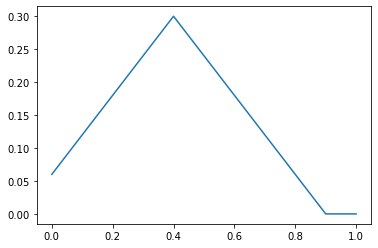

In [8]:
from numpy import arange
plot(arange(0,1.01,0.1),list(map(lambda u: probalong(u, 0.4, probamax=0.3,rankspan=0.8),arange(0,1.01,0.1))))
show()

In [9]:
def estimatebranchingmatrixtype(maxrank = 0.5, probamax = 0.5, rankspan = 0.5):
    longs = [probalong(u, maxrank, probamax, rankspan) for u in np.arange(0,1,0.1)]
    shorts = branchingmatrixtype[:,0]
    inflos = branchingmatrixtype[:,2]
    def normalizeprobas(a,b,c):
        f = (1-b)/(a+c)
        ap = a*f
        cp = c*f
        return (ap,b,cp)
    matrix = [normalizeprobas(a,b,c) for a,b,c in zip(shorts,longs, inflos)]
    return matrix
    
    
    

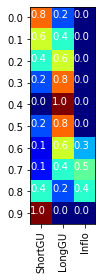

In [10]:
matrix = estimatebranchingmatrixtype(0.4, 1, 0.5)
plot_matrix(matrix, lateraltypes)

## Modelling architecture development

Open in L-Py the model [architecture.lpy](./architecture.lpy) or edit the followig code.

- Change Probability of succession and  branching
- Add rule for flowering GU that always create a lateral short GU and a Flower in terminal position.


### Import of the development function of organs

In [11]:
import os
from openalea.lpy.lsysparameters import LsystemParameters
from training.utils.notebook_util import notebook
organnotebook = 'Organs - solution.ipynb'
exec(notebook(organnotebook))
assert('growth_logistic' in globals())


In [12]:
def seed(value):
    from random import seed
    from numpy.random import seed as rseed
    seed(value)
    rseed(value)

### Graphical parameters

In [13]:
from math import *
from openalea.plantgl.all import Revolution

applesection = NurbsCurve2D([(-0.000874121, -0.389685, 1),(0.0162006, -0.606468, 1),(0.629545, -0.424825, 1),(0.712296, 0.0104895, 1),(0.645105, 0.516783, 1),(-0.00961528, 0.627098, 1),(-0.0171328, 0.394231, 1)])
graphical = LsystemParameters()
graphical.add('applesection', applesection)
graphical.add('SEED',10)
graphical.set_color(10,Material((200,200,200),1))

### Scheduling

These functions manage the current date.
By default, we suppose that group 3 is for mortality. It is call in december.

In [14]:
cdate = None

def get_cdate():
  return cdate

def init_cdate():
  global cdate
  cdate = meteo.get_first_day_for_temperature()+timedelta(days=120)
  return cdate

def increment_cdate(deltatime = 1, winterdelta = 30):
  global cdate
  # in winter, we only compute one day per month
  if cdate.month in list(range(7,13))+list(range(1,4)):
    deltatime = winterdelta
  else:
    deltatime = deltatime
  cdate += timedelta(days=deltatime)
  return cdate

def Start():
  init_cdate()

def StartEach():
  # mortality in december
  if get_cdate().month == 12:   useGroup(3) 
  # standart rules
  else:    useGroup(0)
  increment_cdate()


The function init_meristem should initialize the meristem parameters according to the given fate and type.

In [15]:
def init_meristem(gufate, gutype, parentdate = None, parentlength = None):
  if parentdate is None:
    init_date = date(get_cdate().year, 4, 1)
  elif gufate == Sylleptic:
    init_date = cdate
  else:
    init_date = date(parentdate.year+1, 4, 1)
  assert gutype in [ShortGU, LongGU, Inflo, TrunkGU]
  nbmetamer = growth_unit_length(gutype, parentlength)
  p = ParameterSet(gutype = gutype,
                   gufate = gufate,
                   mp = MetamerProduction(metamerprodrate, nbmetamer),
                   init_date = init_date,
                   processed_date = init_date - timedelta(days=1))
  return p

## Questions:

 - Change probabilities of succession and branching
 - Add rule for flowering GU that always create a lateral short GU and a Flower in terminal position.


In [16]:
%%lpy -w 200 -p graphical 

# Pseudo random generation seed
extern(SEED = 0)
seed(SEED)

module Meristem
module Leaf
module Internode

Axiom:
  init_cdate()
  produce  Meristem(init_meristem(Proleptic,TrunkGU))

derivation length: 200
production:
group 0:

Meristem(p):
  if p.processed_date < get_cdate():
    p.processed_date = get_cdate()
    previousnbmetamer = p.mp.nbmetamer
    nbnewmetamer = p.mp.accumulate_range(p.init_date, get_cdate())
    for i in range(nbnewmetamer):
      rank =  previousnbmetamer+i
      normalizedrank = rank / p.mp.nbfinalmetamer
      nproduce Internode(ParameterSet(length=0.01, finallength = internode_length(rank = rank), width=0.01, ttime = 0, nbchildren = 1))
      nproduce   /(144) [  &(60) Leaf(ParameterSet(area=0, finalarea = leaf_area(rank = rank), ttime = 0)) ]
      ramiffate, ramiftype = branching(p.gutype, normalizedrank, branchingmatrixtype =branchingmatrixtype)
      if ramiffate == Sylleptic and (get_cdate().year >= 2011 or p.gufate == Sylleptic):
        ramiffate = Proleptic
      if ramiffate != Blind:
        nproduce [ &(30) @Tp(0,0,-1) @Ts(0.01) Meristem(init_meristem(ramiffate, ramiftype, p.init_date, p.mp.nbfinalmetamer)) ]
    
    if p.mp.nbmetamer < p.mp.nbfinalmetamer:
      nproduce Meristem(p)
    else:
      # succession
      if p.gutype == Inflo:
        nproduce [ &(15) Meristem(init_meristem(Sylleptic, succession(p.gutype), p.init_date, p.mp.nbfinalmetamer)) ]
        produce Flower(0)
      else:
        # succession
        if p.gutype == TrunkGU:
          nproduce @Tp(0,0,-1) @Ts(0.005)
        
        produce Meristem(init_meristem(Proleptic, succession(p.gutype), p.init_date, p.mp.nbfinalmetamer))

Internode(p) :
  cttime = mthermaltime.get_effective_temperature(get_cdate())
  p.ttime += cttime
  p.length += growth_rate(p.ttime, p.finallength, tip_internode, b_internode)*cttime
  p.width += growth_rate(p.ttime, InternodeRadius, tip_internode, b_internode)*cttime
  produce Internode(p)

Leaf(p):
  cttime = mthermaltime.get_effective_temperature(get_cdate())
  p.ttime += cttime
  p.area += growth_rate(p.ttime, p.finalarea, tip_leaf, b_leaf)*cttime
  produce Leaf(p)


Flower(t):
  if t < 30: produce Flower(t+1)
  else : produce Fruit

group 3:

Leaf(p) --> %
Fruit --> %

interpretation:
group 0:

Internode(p) --> _(p.width) F(p.length)

Leaf(p) :
  if p.area > 0:
    produce ,(2) @g(leafshape, sqrt(p.area / 1.4))


Flower(t) --> [ F(3) ,(10) ,(4) _(0.001) F(3*cos(pi*(t/60.)),3*sin(pi*(t/60.)))  ]
Fruit --> [ @v @h &(90) @Tp(0,0,-1) @Ts(0.1) ,(2) _(0.05) nF(1,0.1)  ,(3) f(1.5) @g(Revolution(applesection),3) ]

endlsystem


# Pipe model

Radius of each internode depends of the number of descendants. 

<center>
    $r_i = r_0 . n_i^{p}$
</center>
with $n_i$ the number of descendants of internode $i$, $r_0$ the radius of the extremity and $p$ the pipe exponent.

Test different value of $r_0$ and $p$.

In [27]:
%%lpy -w 200 -p graphical 

# Pseudo random generation seed
extern(SEED = 0)
seed(SEED)

def StartEach(lstring):
  backward()
  if get_cdate().month == 12:       
        useGroup(3)
  # every 3 day we compute the pipe model
  #elif getIterationNb() % 3 == 0 :   useGroup(2)
  else : useGroup(0)
  increment_cdate(1,3)


def EndEach():
  if get_cdate().year == 2012 and get_cdate().month == 9:
    print(getIterationNb())
    Stop()
    
def End():
    print(get_cdate())

module Meristem
module Leaf
module Internode

radiusconstant = 0.27
radiusexponent = 0.27

Axiom:
  init_cdate()
  produce  Meristem(init_meristem(Proleptic,TrunkGU))

derivation length: 450
production:
group 0:

Meristem(p):
  if p.processed_date < get_cdate():
    p.processed_date = get_cdate()
    previousnbmetamer = p.mp.nbmetamer
    nbnewmetamer = p.mp.accumulate_range(p.init_date, get_cdate())
    for i in range(nbnewmetamer):
      rank =  previousnbmetamer+i
      normalizedrank = rank / p.mp.nbfinalmetamer
      nproduce Internode(ParameterSet(length=0.01, finallength = internode_length(rank = rank), width=0.01, ttime = 0, nbchildren = 1))
      nproduce   /(144) # [  &(60) Leaf(ParameterSet(area=0, finalarea = leaf_area(rank = rank), ttime = 0)) ]
      ramiffate, ramiftype = branching(p.gutype, normalizedrank, branchingmatrixtype =branchingmatrixtype)
      if ramiffate == Sylleptic and (get_cdate().year >= 2011 or p.gufate == Sylleptic):
        ramiffate = Proleptic
      if ramiffate != Blind:
        nproduce [ &(30) @Tp(0,0,-1) @Ts(0.01) Meristem(init_meristem(ramiffate, ramiftype, p.init_date, p.mp.nbfinalmetamer)) ]
    
    if p.mp.nbmetamer < p.mp.nbfinalmetamer:
      nproduce Meristem(p)
    else:
      # succession
      if p.gutype == Inflo:
        nproduce [ &(15) Meristem(init_meristem(Sylleptic, succession(p.gutype), p.init_date, p.mp.nbfinalmetamer)) ]
        # produce Flower(0)
      else:
        # succession
        if p.gutype == TrunkGU:
          nproduce @Tp(0,0,-1) @Ts(0.005)
        
        produce Meristem(init_meristem(Proleptic, succession(p.gutype), p.init_date, p.mp.nbfinalmetamer))        

# group 2:
consider: Internode, Meristem
Internode(p) >> []  x([Internode(pb)]) x([Meristem(pm)]) x(Internode(pa),1) :
    p.nbchildren = sum([pi.nbchildren for pi in pb])+sum([pi.nbchildren for pi in pa])+1
  
    cttime = mthermaltime.get_effective_temperature(cdate)
    p.ttime += cttime
  
    p.length += growth_rate(p.ttime, p.finallength, tip_internode, b_internode)*cttime
    p.width = radiusconstant * pow(p.nbchildren, radiusexponent)
  
    produce Internode(p)

group 0:        
Internode(p) :
      cttime = mthermaltime.get_effective_temperature(get_cdate())
      p.ttime += cttime
      p.length += growth_rate(p.ttime, p.finallength, tip_internode, b_internode)*cttime
      produce Internode(p)

Leaf(p):
  cttime = mthermaltime.get_effective_temperature(get_cdate())
  p.ttime += cttime
  p.area += growth_rate(p.ttime, p.finalarea, tip_leaf, b_leaf)*cttime
  produce Leaf(p)


Flower(t):
  if t < 30: produce Flower(t+1)
  else : produce Fruit

group 3:

Leaf(p) --> %
Fruit --> %

interpretation:
group 0:

Internode(p) --> _(p.width) F(p.length)

Leaf(p) :
  if p.area > 0:
    produce ,(2) @g(leafshape, sqrt(p.area / 1.4))


Flower(t) --> [ F(3) ,(10) ,(4) _(0.001) F(3*cos(pi*(t/60.)),3*sin(pi*(t/60.)))  ]
Fruit --> [ @v @h &(90) @Tp(0,0,-1) @Ts(0.1) ,(2) _(0.05) nF(1,0.1)  ,(3) f(1.5) @g(Revolution(applesection),3) ]

endlsystem


<string>:48: Warning: Found symbol '#' after Lstring. Considered as begining of comments


445
446
447
448
449
450
2012-09-17
